In [1]:
# Based on Jupyter Notebook created by Josh Tobin for CS 189 at UC Berkeley

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from timeit import default_timer as timer

# Part 1: Create a synthetic dataset


## Let's generate some data from a polynomial

$$y_i = -0.1 x_i^4 - 0.4 x_i^3 - 0.5 x_i^2 + 0.5 x_i + 1 + \epsilon_i\text{, where }\epsilon_i \sim \mathcal{N}(0,0.1), x_i \sim \mathrm{Uniform}(-1,1)$$





$$ y_i = -0.1 x_i^4 - 0.4 x_i^3 - 0.5 x_i^2 + 0.5 x_i + 1 + \epsilon_i\text{, where }\epsilon_i \sim \mathcal{N}(0,0.1), x_i \sim \mathrm{Uniform}(-1,1) $$



In [2]:
def polynomial(values, coeffs):
    assert len(values.shape) == 2
    # Coeffs are assumed to be in order 0, 1, ..., n-1
    expanded = coeffs[np.newaxis,:] * (values ** np.arange(len(coeffs))[np.newaxis,:])
    return np.sum(expanded, axis=-1)

In [3]:
def polynomial_data(coeffs, n_data=100, x_range=[-1, 1], eps=0.1):
    # generate uniform distro x
    x = np.random.uniform(x_range[0], x_range[1], n_data)[:,np.newaxis]
    # compute polynomial
    poly = polynomial(x, coeffs)
    # add noises
    noisy_poly = poly + eps * np.random.standard_normal(size=poly.shape)
    return x, noisy_poly

In [38]:
np.random.seed(100)
# 1 + 0.5 * x - 0.5 x^2 - 0.4 x^3 - 0.1 x^4
coeffs = np.array([1., 0.5, -0.5, -0.4, -0.1])
# generate 50 data points
x, y = polynomial_data(coeffs, 50)

## Let's inspect it

In [5]:
# Good to look at shapes, some values
print(x.shape)
print(y.shape)
print(x[:5])
print(y[:5])

(50, 1)
(50,)
[[ 0.08680988]
 [-0.44326123]
 [-0.15096482]
 [ 0.68955226]
 [-0.99056229]]
[1.15833183 0.54204386 0.77880678 0.83003521 0.25217139]


In [6]:
def plot_polynomial(coeffs, x_range=[-1, 1], color='red', label='polynomial', alpha=1.0):
    values = np.linspace(x_range[0], x_range[1], 1000).reshape([-1, 1])
    poly = polynomial(values, coeffs)
    plt.plot(values, poly, color=color, linewidth=2, label=label, alpha=alpha)

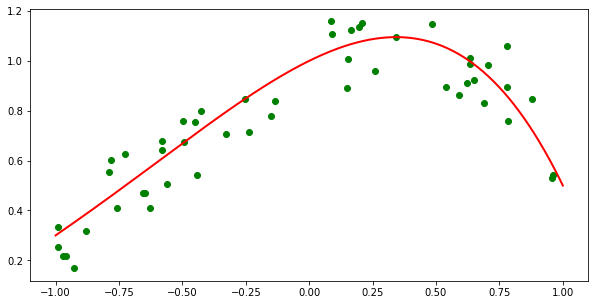

In [7]:
plt.figure(figsize=(10, 5))
# scatter noisy points
plt.scatter(x, y, color='green')
# plot function
plot_polynomial(coeffs)

# Part 2: Ordinary least squares (OLS)

## Let's code up a naive implementation of the OLS solution

$$L(\vec{w}) = \sum_{i=1}^{N} (y_i - \vec{w}^\top\vec{x}_i)^2 = \Vert \vec{y} - X\vec{w} \Vert_2^2$$

$$\tilde{L}(\vec{w}) := {1 \over N}L(\vec{w}) = {1 \over N}\sum_{i=1}^{N} (y_i - \vec{w}^\top\vec{x}_i)^2 \text{ ("Mean Squared Error")}$$

$$\vec{w}^{*} := \arg \min_{\vec{w}} \tilde{L}(\vec{w}) = \arg \min_{\vec{w}} L(\vec{w}) =  \left( X^\top X \right)^{-1} X^\top \vec{y} = X^\dagger \vec{y}, \text{where } X = \left(\begin{matrix}
\vec{x}_1^\top \\
\vdots \\
\vec{x}_N^\top \\
\end{matrix}\right) \text{ and } \vec{y}= \left(\begin{matrix}
y_{1} \\
\vdots \\
y_{N} \\
\end{matrix}\right) $$

In [8]:
def least_squares(x, y):
    xTx = x.T.dot(x)
    xTx_inv = np.linalg.inv(xTx)
    w = xTx_inv.dot(x.T.dot(y))
    return w

In [9]:
def avg_loss(x, y, w):
  y_hat = x.dot(w)
  loss = np.mean((y - y_hat) ** 2)
  return loss

## How well does it work?

$$\hat{y} := wx + b$$

This is equivalent to:

$$\hat{y} = \vec{w}^\top\vec{x}\text{ where }\vec{w} = \left(\begin{matrix}
w \\
b \\
\end{matrix}\right)\text{ and }\vec{x} = \left(\begin{matrix}
x \\
1 \\
\end{matrix}\right)$$

In [10]:
augmented_x = np.hstack([np.ones_like(x), x])

linear_coeff = least_squares(augmented_x, y)

loss = avg_loss(augmented_x, y, linear_coeff)

0.03848975511265433


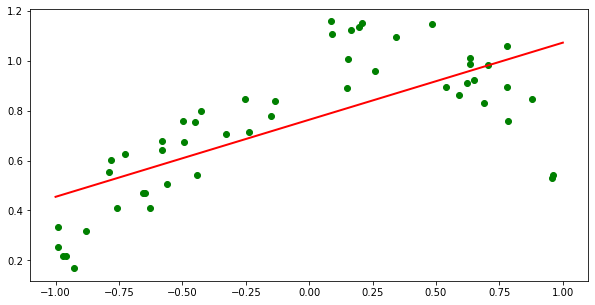

In [11]:
plt.figure(figsize=(10, 5))
plt.scatter(x, y, color='green')
plot_polynomial(linear_coeff)
print(loss)

# Part 3: Polynomial features

$$\vec{x} = \left(\begin{matrix}
1 \\
x \\
x^2 \\
\vdots \\
x^d \\
\end{matrix}\right)$$

$$\hat{y} = \vec{w}^\top\vec{x}\text{ where }\vec{w} = \sum_{i=1}^{d}w_i x^i$$

Can fit a model that is *non-linear* in the input with *linear* regression!

In [12]:
def polynomial_features(x, order):
    features = x ** np.arange(order+1)[np.newaxis,:]
    return features

In [13]:
def plot_regression(x, y, degree):
    start = timer()
    features = polynomial_features(x, degree)
    w = least_squares(features, y)
    loss = avg_loss(features, y, w)
    end = timer()
    
    plt.figure(figsize=(10, 5))
    plt.scatter(x, y, color='green')
    plot_polynomial(w)
    plt.title(f"Polynomial degree: {degree}, loss: {loss}, time: {end-start}")

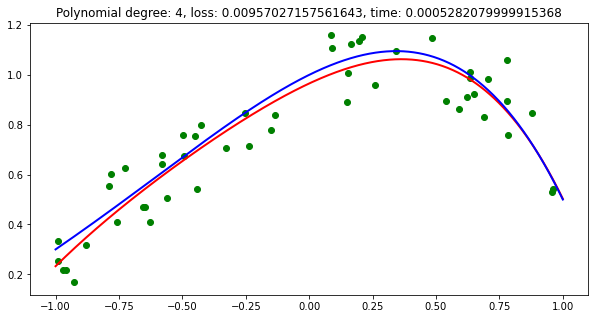

In [14]:
plot_regression(x, y, 4)
plot_polynomial(coeffs, color='blue')

# Part 4: Hyperparameters

What degree of polynomial features should we choose? (Previously we picked 4 because we know how the data was generated, but in practice we don't.)

This is known as "model selection", since different hyperparameter choices result in different models, so we are effectively choosing the model. 

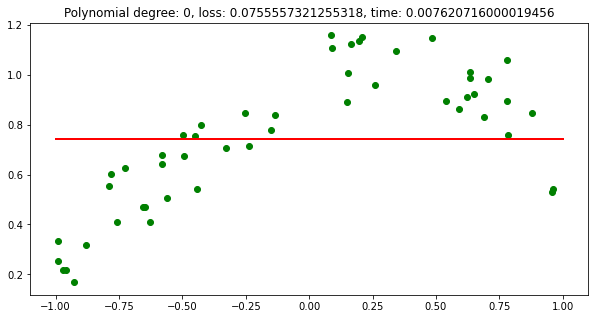

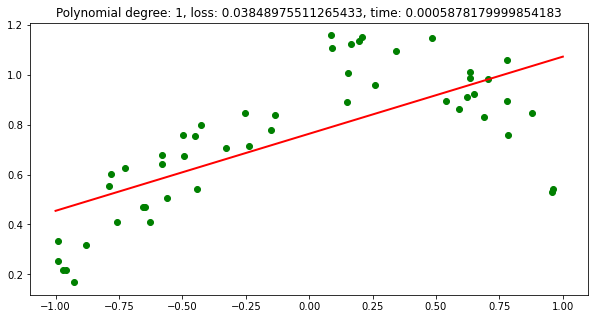

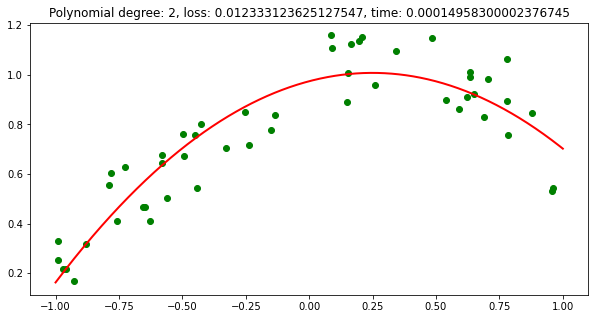

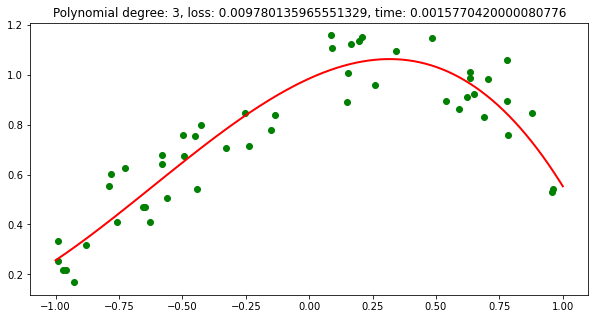

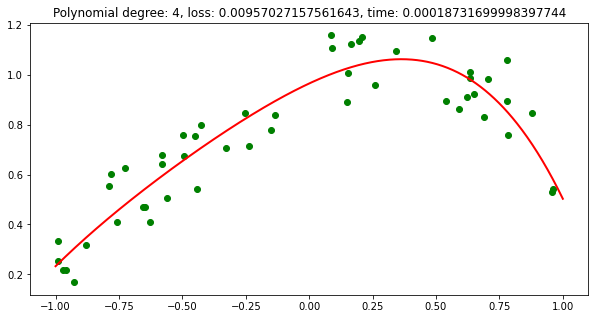

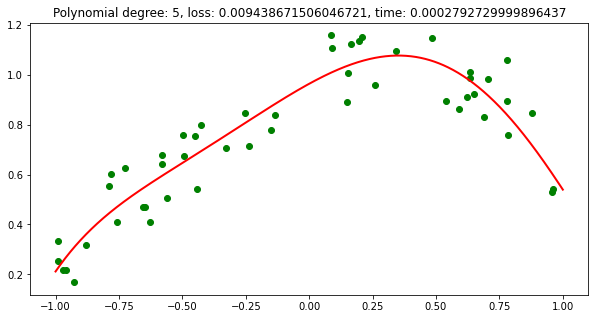

In [15]:
times = []
errs = []
for degree in range(0, 6):
    plot_regression(x, y, degree)

In [16]:
def plot_losses(losses, label='loss', color='b'):
    plt.plot(losses, color=color, label=label)
    plt.semilogy()
    plt.legend()
    plt.title(f"Minimum loss achieved at hyperparam value {np.argmin(losses)}")
    plt.xticks(np.arange(len(losses)))

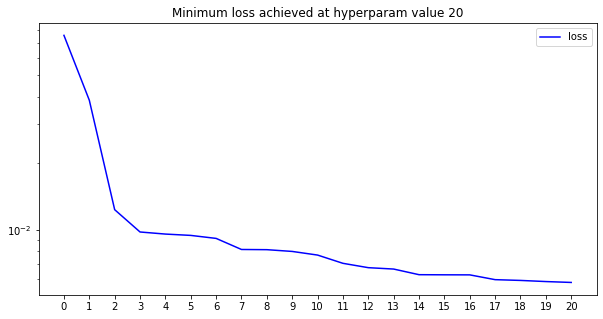

In [17]:
losses = np.empty((21,))
for degree in range(21):
    features = polynomial_features(x, degree)
    w = least_squares(features, y)
    loss = avg_loss(features, y, w)
    losses[degree] = loss

plt.figure(figsize=(10, 5))
plot_losses(losses)

Loss never goes up as we increase the degree!

## Should we choose degree 20?

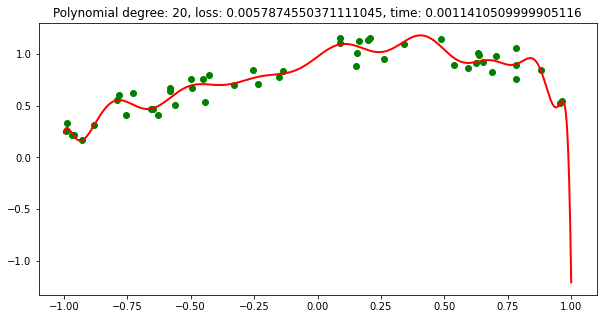

In [18]:
plot_regression(x, y, 20)

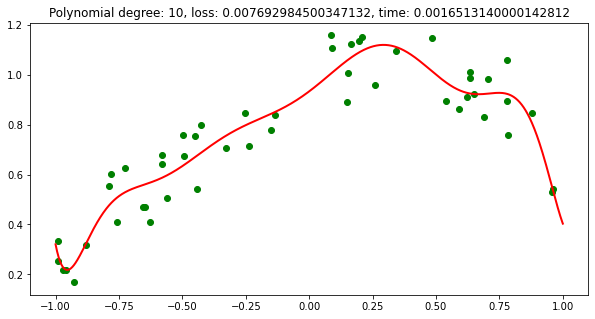

In [19]:
plot_regression(x, y, 10)

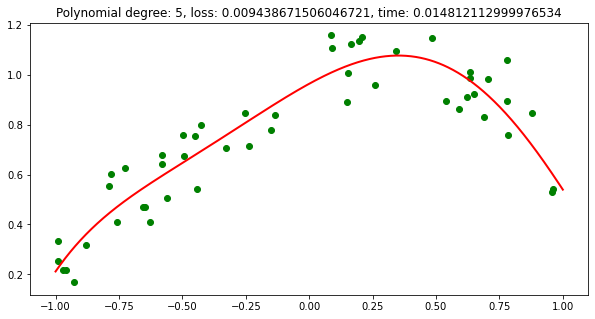

In [20]:
plot_regression(x, y, 5)

## Why does this happen?

$$\text{Recall }\vec{w}^{*} = X^\dagger \vec{y} \text{ and } X^\dagger = V \Sigma^{-1} U^\top $$

$$\text{Let's take a look at the singular values of }X \text{, i.e.: diagonal entries of }\Sigma$$

In [21]:
features_20 = polynomial_features(x, 20)
features_20.shape

(50, 21)

In [22]:
_, singular_values_20, _ = np.linalg.svd(features_20)
# low singlur value means XTX is almost not invertible, 1/singular_val very large
# W is very large
singular_values_20.min()

1.781936279860198e-07

In [23]:
features_5 = polynomial_features(x, 5)
features_5.shape

(50, 6)

In [24]:
_, singular_values_5, _ = np.linalg.svd(features_5)
singular_values_5.min()

0.17466830300280697

$$\text{Very small singular value - } X^\top X \text{ is close to being non-invertible. As a result, computing }X^\top X \text{ and }X^\dagger\text{ is numerically unstable.}$$

In [25]:
w_20 = least_squares(features_20, y)
# large coefficient, predictive output sensitive to small change of input
np.abs(w_20).max()

163752.68359375

In [26]:
w_5 = least_squares(features_5, y)
np.abs(w_5).max()

0.9642883386518912

$$\text{Since }\vec{w}^{*} := \left( X^\top X \right)^{-1} X^\top \vec{y} = X^\dagger \vec{y}\text{, small singular values of }X\text{ causes }\vec{w}^{*}\text{ to have elements that are large in magnitude.}$$

$$\text{This is bad - large coordinate values of }\vec{w}^{*}\text{ make the prediction sensitive to tiny changes in the input. As a result, the model is not robust to noise in the input.}$$

## What happens if we generate new data?

In [27]:
np.random.seed(200)
x_new, y_new = polynomial_data(coeffs, 50)

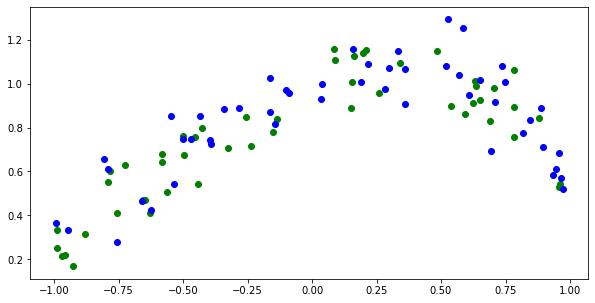

In [28]:
plt.figure(figsize=(10, 5))
plt.scatter(x, y, color='green')
plt.scatter(x_new, y_new, color='blue')

In [29]:
def plot_regression_new(x, y, x_new, y_new, degree, y_axis_limits = None):
    start = timer()
    features = polynomial_features(x, degree)
    w = least_squares(features, y)
    loss = avg_loss(features, y, w)
    end = timer()

    features_new = polynomial_features(x_new, degree)
    loss_new = avg_loss(features_new, y_new, w)

    plt.figure(figsize=(10, 5))
    plt.scatter(x, y, color='green')
    plt.scatter(x_new, y_new, color='blue')
    plot_polynomial(w)
    if y_axis_limits is not None:
      plt.ylim(y_axis_limits)
    plt.title(f"Polynomial degree: {degree}, loss: {loss}, loss (new): {loss_new}")

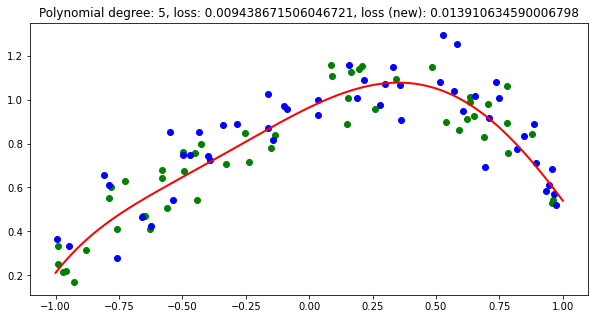

In [30]:
plot_regression_new(x, y, x_new, y_new, 5)

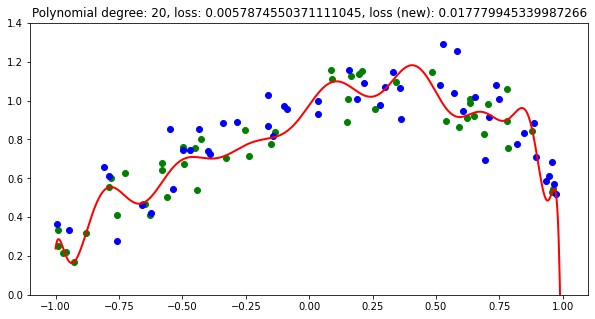

In [31]:
plot_regression_new(x, y, x_new, y_new, 20, y_axis_limits=(0.0, 1.4))

High-degree polynomial doesn't generalize as well to new data.

Old data which we have access to is known as "training data" or "train data".

New data which we don't have access to is known as "testing data" or "test data".

Loss on the old data is known as "training loss" or "train loss", loss on the new data is known as "testing loss" or "test loss".

Testing loss should approximate the loss we expect the model to incur when it is fed real unseen data. 

When both training loss and testing loss are low, the model is said to "generalize" to the testing data.

When testing loss is much higher than the training loss, the model is fitted *too* well to the training data. It fails to generalize to testing data and is said to be "overfitting".

When testing loss is similar to the training loss and is high, the model is not fitted well enough to the training data. In this case, it is said to be "underfitting".

## Another Problem: Instability

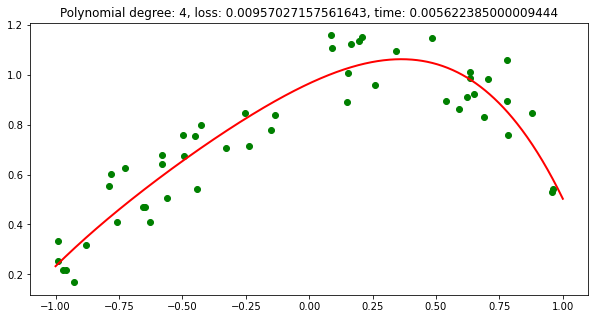

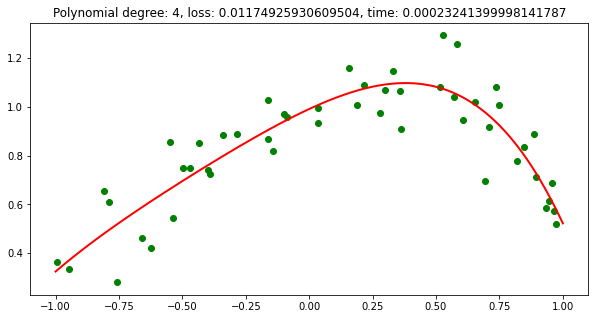

In [32]:
plot_regression(x, y, 4)
plot_regression(x_new, y_new, 4)

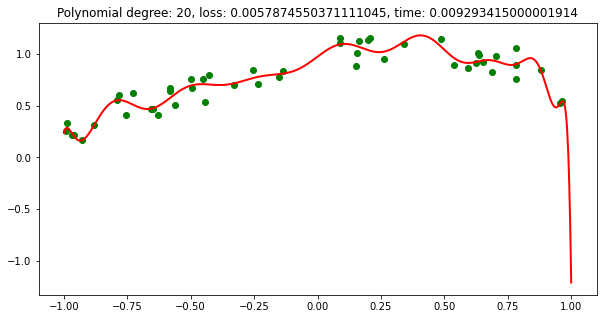

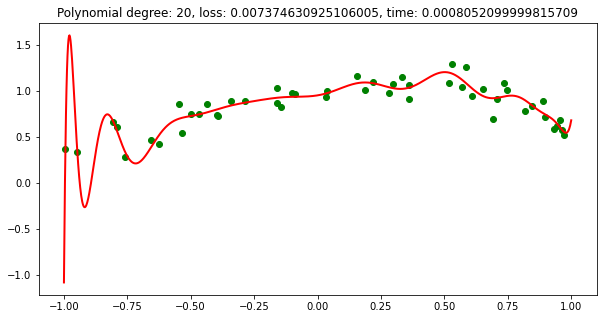

In [33]:
plot_regression(x, y, 20)
plot_regression(x_new, y_new, 20)

This instability is another sign of overfitting.

## What happens if we had more data?

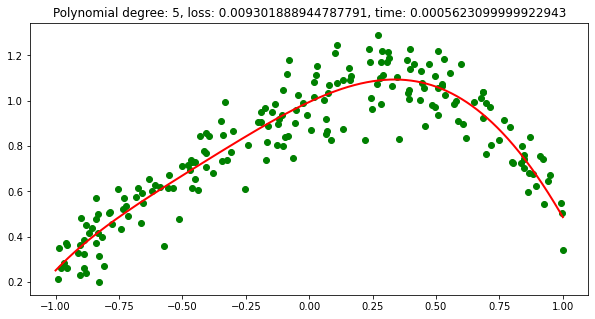

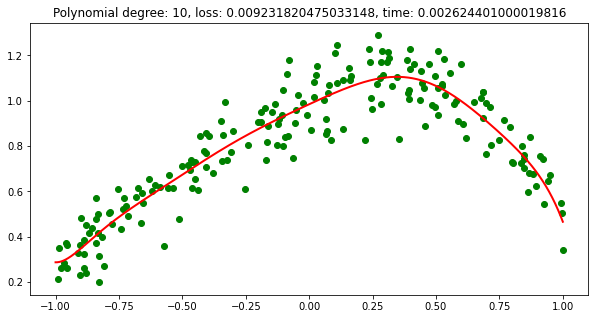

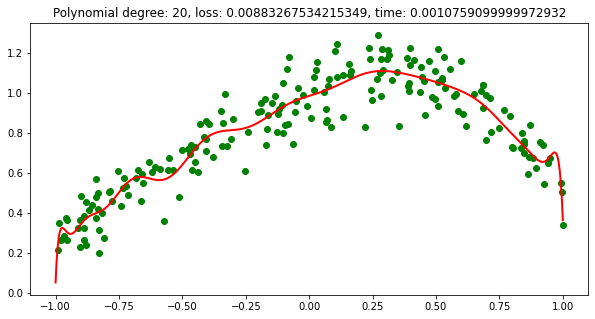

In [34]:
x_big, y_big = polynomial_data(coeffs, 200)
plot_regression(x_big, y_big, 5)
plot_regression(x_big, y_big, 10)
plot_regression(x_big, y_big, 20)

## Back to picking the optimal hyperparameters

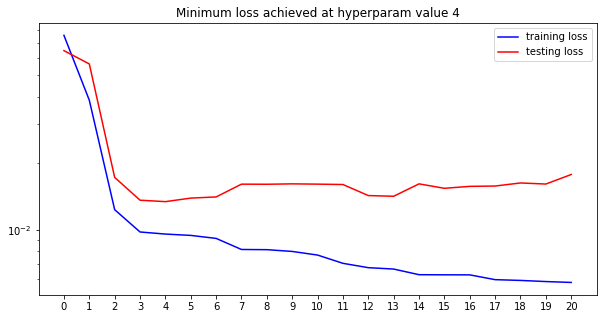

In [35]:
train_losses = []
test_losses = []
for degree in range(21):
    features = polynomial_features(x, degree)
    w = least_squares(features, y)
    train_loss = avg_loss(features, y, w)
    train_losses.append(train_loss)

    features_new = polynomial_features(x_new, degree)
    test_loss = avg_loss(features_new, y_new, w)
    test_losses.append(test_loss)

plt.figure(figsize=(10, 5))
plot_losses(train_losses, label='training loss', color='b')
plot_losses(test_losses, label='testing loss', color='r')

The difference between the training loss and the testing loss is known as the "generalization gap".

Would like to pick the hyperparameter that results in the lowest testing loss - but can't use testing loss for training or model selection! (Otherwise will overfit to the testing set and make the testing set pointless)

## A Realistic Approach: Validation Sets

Idea: Divide our data into two subsets. Then train model on one subset and pick the hyperparameters based on the other subset.

In [36]:
N_TRAIN = x.shape[0] // 2
x_train, y_train = x[:N_TRAIN], y[:N_TRAIN]
x_val, y_val = x[N_TRAIN:], y[N_TRAIN:]

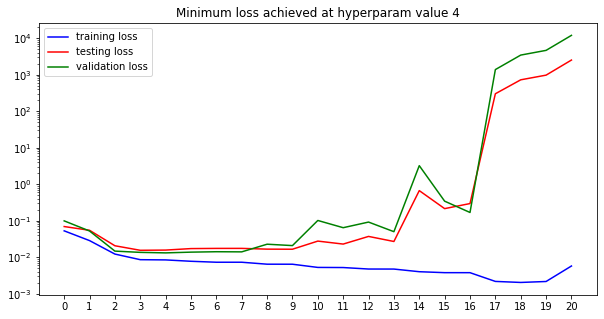

In [37]:
train_losses = []
val_losses = []
test_losses = []
for degree in range(21):
    features_train = polynomial_features(x_train, degree)
    w = least_squares(features_train, y_train)
    train_loss = avg_loss(features_train, y_train, w)
    train_losses.append(train_loss)

    features_val = polynomial_features(x_val, degree)
    val_loss = avg_loss(features_val, y_val, w)
    val_losses.append(val_loss)

    features_new = polynomial_features(x_new, degree)
    test_loss = avg_loss(features_new, y_new, w)
    test_losses.append(test_loss)

plt.figure(figsize=(10, 5))
plot_losses(train_losses, label='training loss', color='b')
plot_losses(test_losses, label='testing loss', color='r')
plot_losses(val_losses, label='validation loss', color='g')